# **MLS 1: Decision Trees and Random Forest - Employee Attrition**

### Note:

Kindly **do not** run the code cells containing Hyperparameter Tuning using GridSearchCV during the session, 

since **they take considerable time to run.**

-----
## **Context:**
-----

McCurr Health Consultancy is an MNC that has thousands of employees spread across the globe. The company believes in hiring the best talent available and retaining them for as long as possible. A huge amount of resources is spent on retaining existing employees through various initiatives. The Head of People Operations wants to bring down the cost of retaining employees. For this, he proposes limiting the incentives to only those employees who are at risk of attrition. As a recently hired Data Scientist in the People Operations Department, you have been asked to identify patterns in characteristics of employees who leave the organization. Also, you have to use this information to **predict if an employee is at risk of attrition.** This information will be used to target them with incentives.

-----
## **Objective:** 
-----

* To identify the different factors that drive attrition
* To make a model to predict the attrition

-----
## **Dataset:**
-----

The data contains demographic details, work-related metrics and attrition flag.

* **EmployeeNumber -** Employee Identifier
* **Attrition -** Did the employee attrite?
* **Age -** Age of the employee
* **BusinessTravel -** Travel commitments for the job
* **DailyRate -** Data description not available**
* **Department -** Employee Department
* **DistanceFromHome -** Distance from work to home (in km)
* **Education -** 1-Below College, 2-College, 3-Bachelor, 4-Master,5-Doctor
* **EducationField -** Field of Education
* **EnvironmentSatisfaction** - 1-Low, 2-Medium, 3-High, 4-Very High
* **Gender** - Employee's gender
* **HourlyRate** - Data description not available**
* **JobInvolvement** - 1-Low, 2-Medium, 3-High, 4-Very High
* **JobLevel** - Level of job (1 to 5)
* **JobRole** - Job Roles
* **JobSatisfaction** - 1-Low, 2-Medium, 3-High, 4-Very High
* **MaritalStatus** - Marital Status
* **MonthlyIncome** - Monthly Salary
* **MonthlyRate** - Data description not available**
* **NumCompaniesWorked** - Number of companies worked at
* **Over18** - Over 18 years of age?
* **OverTime** - Overtime?
* **PercentSalaryHike** - The percentage increase in salary last year
* **PerformanceRating** - 1-Low, 2-Good, 3-Excellent, 4-Outstanding
* **RelationshipSatisfaction** - 1-Low, 2-Medium, 3-High, 4-Very High
* **StandardHours** - Standard Hours
* **StockOptionLevel** - Stock Option Level
* **TotalWorkingYears** - Total years worked
* **TrainingTimesLastYear** - Number of training attended last year
* **WorkLifeBalance** - 1-Low, 2-Good, 3-Excellent, 4-Outstanding
* **YearsAtCompany** - Years at Company
* **YearsInCurrentRole** - Years in the current role
* **YearsSinceLastPromotion** - Years since the last promotion
* **YearsWithCurrManager** - Years with the current manager

**In the real world, you will not find definitions for some of your variables. It is a part of the analysis to figure out what they might mean.**

### **Importing the necessary libraries**

In [1]:
#! pip install jupyter_contrib_nbextensions
#! jupyter contrib nbextension install --user
#! jupyter nbextension enable spellchecker/main

In [2]:
import warnings
warnings.filterwarnings('ignore')

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#to scale the data using z-score 
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split

#algorithms to use
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

#Metrics to evaluate the model
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve,recall_score
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier

#for tuning the model
from sklearn.model_selection import GridSearchCV

In [4]:
sns.set(font_scale=1.025, rc={'figure.figsize': (10, 6),
                              'axes.facecolor': '#f2f2f0',
                              'axes.edgecolor': '#f2f2f0',
                              'figure.facecolor': '#f2f2f0', 
                              'grid.color': '#c4c4c4', 
                              'grid.linewidth': 0.5,
                              'lines.linewidth': 1.5,
                              'text.color': '#000000',
                              'xtick.color': '#000000',
                              'ytick.color': '#000000'})

#### Utility Functions 

In [5]:
def triag_corr(df: pd.DataFrame, fig_xy: list = [13,10], cmap: str = 'rocket', annot: bool = True, annot_s: int = 8, 
               fmt: str = ".3%", abs_: bool = False, method: str = 'pearson') -> plt.figure:
    plt.figure(figsize=(fig_xy[0], fig_xy[1]))
    corr = df.corr(method=method).abs() if abs_ else df.corr(method=method)
    mask = np.tri(*corr.shape).T 
    sns.heatmap(corr, mask=mask, cmap=cmap, annot=annot, annot_kws={"size":annot_s}, fmt=fmt)
    plt.show()
    
def get_redundant_pairs(df: pd.DataFrame) -> set:
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def mu_std_corr_matrix(corr: pd.DataFrame or np.array, rnd: int = 3):
    corr = corr.abs().copy()
    corr.values[np.tril_indices_from(corr)] = np.nan     
    return (round(corr.unstack().mean(),rnd), round(corr.unstack().std(),rnd))

def get_top_abs_correlations(df: pd.DataFrame, n: int = 5) -> pd.Series:
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)\
                     .to_frame().rename(columns={0:'Correlation'}).rename_axis(['X', 'y'])
    return au_corr[0:n]

def bin_count(data):
    bins = np.sqrt(len(data))
    return int(bins)

### **Reading the dataset**

In [6]:
#reading the dataset
df = pd.read_excel('HR_Employee_Attrition_Dataset.xlsx')

In [7]:
df.head()

,EmployeeNumber,Attrition,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,1,Yes,41,Travel_Rarely,1102,Sales,1,2,Life Sciences,2,...,1,80,0,8,0,1,6,4,0,5
1,2,No,49,Travel_Frequently,279,Research & Development,8,1,Life Sciences,3,...,4,80,1,10,3,3,10,7,1,7
2,3,Yes,37,Travel_Rarely,1373,Research & Development,2,2,Other,4,...,2,80,0,7,3,3,0,0,0,0
3,4,No,33,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,4,...,3,80,0,8,3,3,8,7,3,0
4,5,No,27,Travel_Rarely,591,Research & Development,2,1,Medical,1,...,4,80,1,6,3,3,2,2,2,2


### **Printing the info**

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2940 entries, 0 to 2939
Data columns (total 34 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   EmployeeNumber            2940 non-null   int64 
 1   Attrition                 2940 non-null   object
 2   Age                       2940 non-null   int64 
 3   BusinessTravel            2940 non-null   object
 4   DailyRate                 2940 non-null   int64 
 5   Department                2940 non-null   object
 6   DistanceFromHome          2940 non-null   int64 
 7   Education                 2940 non-null   int64 
 8   EducationField            2940 non-null   object
 9   EnvironmentSatisfaction   2940 non-null   int64 
 10  Gender                    2940 non-null   object
 11  HourlyRate                2940 non-null   int64 
 12  JobInvolvement            2940 non-null   int64 
 13  JobLevel                  2940 non-null   int64 
 14  JobRole                 

**Observation:**
- There are 2940 observations and 33 columns.
- All the column have 2940 non-null values i.e. **there are no missing values in the data.**

**Let's check the unique values in each column** 

In [9]:
#checking unique values in each column
df.nunique()

EmployeeNumber              2940
Attrition                      2
Age                           43
BusinessTravel                 3
DailyRate                    886
Department                     3
DistanceFromHome              29
Education                      5
EducationField                 6
EnvironmentSatisfaction        4
Gender                         2
HourlyRate                    71
JobInvolvement                 4
JobLevel                       5
JobRole                        9
JobSatisfaction                4
MaritalStatus                  3
MonthlyIncome               1349
MonthlyRate                 1427
NumCompaniesWorked            10
Over18                         1
OverTime                       2
PercentSalaryHike             15
PerformanceRating              2
RelationshipSatisfaction       4
StandardHours                  1
StockOptionLevel               4
TotalWorkingYears             40
TrainingTimesLastYear          7
WorkLifeBalance                4
YearsAtCom

**Observation:**
- **Employee number is an identifier** which is unique for each employee and **we can drop this column** as it would not add any value to our analysis.
- **Over18 and StandardHours have only 1 unique value.** These columns will not add any value to our model hence we can drop them.
- On the basis of number of unique values in each column and the data description, we can identify the continuous and categorical columns in the data.

**Let's drop the columns mentioned above** and define lists for numerical and categorical columns to apply explore them separately.

In [10]:
#dropping the columns 
df=df.drop(['EmployeeNumber','Over18','StandardHours'], axis=1)

In [11]:
#Creating numerical columns
num_cols=['DailyRate','Age','DistanceFromHome','MonthlyIncome','MonthlyRate','PercentSalaryHike','TotalWorkingYears',
          'YearsAtCompany','NumCompaniesWorked','HourlyRate','YearsInCurrentRole','YearsSinceLastPromotion',
          'YearsWithCurrManager','TrainingTimesLastYear']

#Creating categorical variables 
cat_cols= ['Attrition','OverTime','BusinessTravel', 'Department','Education', 'EducationField','JobSatisfaction',
           'EnvironmentSatisfaction','WorkLifeBalance','StockOptionLevel','Gender', 'PerformanceRating', 'JobInvolvement',
           'JobLevel', 'JobRole', 'MaritalStatus','RelationshipSatisfaction']

### **Exploratory Data Analysis and Data Preprocessing**

**Note:** We have explored this data earlier in the case study for classification course. Here, we will simply look at some basic univariate analysis and data preprocessing and move to the model building section.

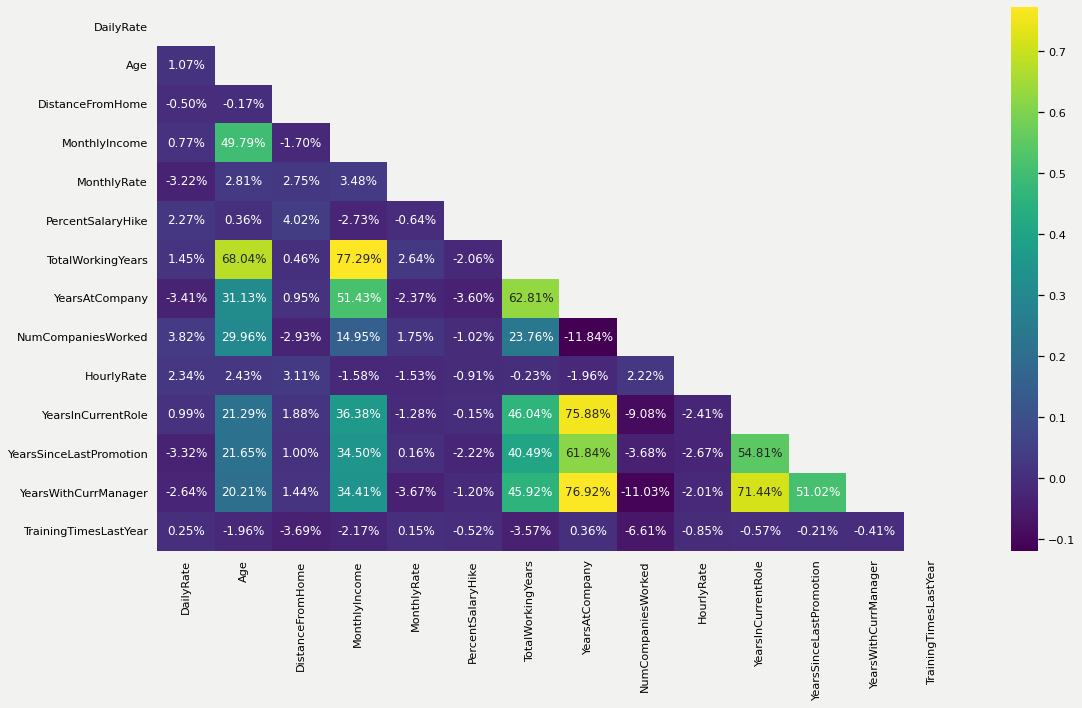

In [12]:
triag_corr(
    df=df[num_cols], 
    fig_xy=[18,10],
    abs_=False,
    cmap='viridis',
    method='pearson',
    fmt='.2%',
    annot_s=12
)

In [13]:
mu_abs_corr, std_abs_corr = mu_std_corr_matrix(corr=df[num_cols].corr(), rnd=3)
top_abs_corrs = get_top_abs_correlations(
    df[num_cols].select_dtypes(include=np.number), 
    20
)
top_abs_corrs.head()

Correlation
X                  y                                
MonthlyIncome      TotalWorkingYears        0.772893
YearsAtCompany     YearsWithCurrManager     0.769212
                   YearsInCurrentRole       0.758754
YearsInCurrentRole YearsWithCurrManager     0.714365
Age                TotalWorkingYears        0.680381

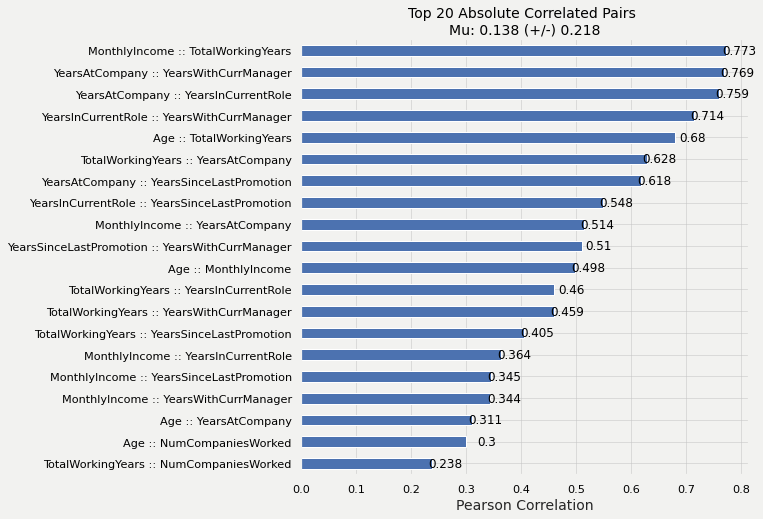

In [14]:
abs_corrs_idx = [str(i)+' :: '+str(x) for i, x in zip(top_abs_corrs.index.droplevel(1), top_abs_corrs.index.droplevel(0))]
top_abs_corrs = pd.DataFrame(top_abs_corrs.values, index=abs_corrs_idx, columns=['Correlation'])

fig, ax = plt.subplots(figsize=(8,8))
top_abs_corrs.sort_values('Correlation').plot(kind='barh', ax=ax, legend=False)
for i, v in enumerate(top_abs_corrs.sort_values('Correlation').values):
    ax.text(x=v + 0.055, y=i, s=str(round(v[0],3)), fontweight='medium', fontsize=12, 
        va='center', ha='right')
plt.title(f'Top 20 Absolute Correlated Pairs \nMu: {mu_abs_corr} (+/-) {std_abs_corr}', fontsize=14)
plt.xlabel('Pearson Correlation', fontsize=14);

### **Univariate analysis of numerical columns**

In [15]:
#Checking summary statistics
df[num_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
DailyRate,2940.0,802.485714,403.440447,102.0,465.0,802.0,1157.0,1499.0
Age,2940.0,36.923810,9.133819,18.0,30.0,36.0,43.0,60.0
DistanceFromHome,2940.0,9.192517,8.105485,1.0,2.0,7.0,14.0,29.0
MonthlyIncome,2940.0,6502.931293,4707.155770,1009.0,2911.0,4919.0,8380.0,19999.0
MonthlyRate,2940.0,14313.103401,7116.575021,2094.0,8045.0,14235.5,20462.0,26999.0
PercentSalaryHike,2940.0,15.209524,3.659315,11.0,12.0,14.0,18.0,25.0
TotalWorkingYears,2940.0,11.279592,7.779458,0.0,6.0,10.0,15.0,40.0
YearsAtCompany,2940.0,7.008163,6.125483,0.0,3.0,5.0,9.0,40.0
NumCompaniesWorked,2940.0,2.693197,2.497584,0.0,1.0,2.0,4.0,9.0
HourlyRate,2940.0,65.891156,20.325969,30.0,48.0,66.0,84.0,100.0


- **Average employee age is around 37 years**. It has a high range, from 18 years to 60, indicating good age diversity in the organization.
- **At least 50% of the employees live within a 7 km radius** from the organization. However there are some extreme values, seeing as the maximum value is 29 km.
- **The average monthly income of an employee is USD 6500.** It has a high range of values from 1K-20K, which is to be expected for any organization's income distribution. There is a big difference between the 3rd quartile value (around USD 8400) and the maximum value (nearly USD 20000), showing that the **company's highest earners have a disproportionately large income** in comparison to the rest of the employees. Again, this is fairly common in most organizations.
- **Average salary hike of an employee is around 15%.** At least 50% of employees got a salary hike 14% or less, with the maximum salary hike being 25%.
- Average number of years an employee is associated with the company is 7. 
- **On average, the number of years since an employee got a promotion is 2.18**. The majority of employees have been promoted since the last year.

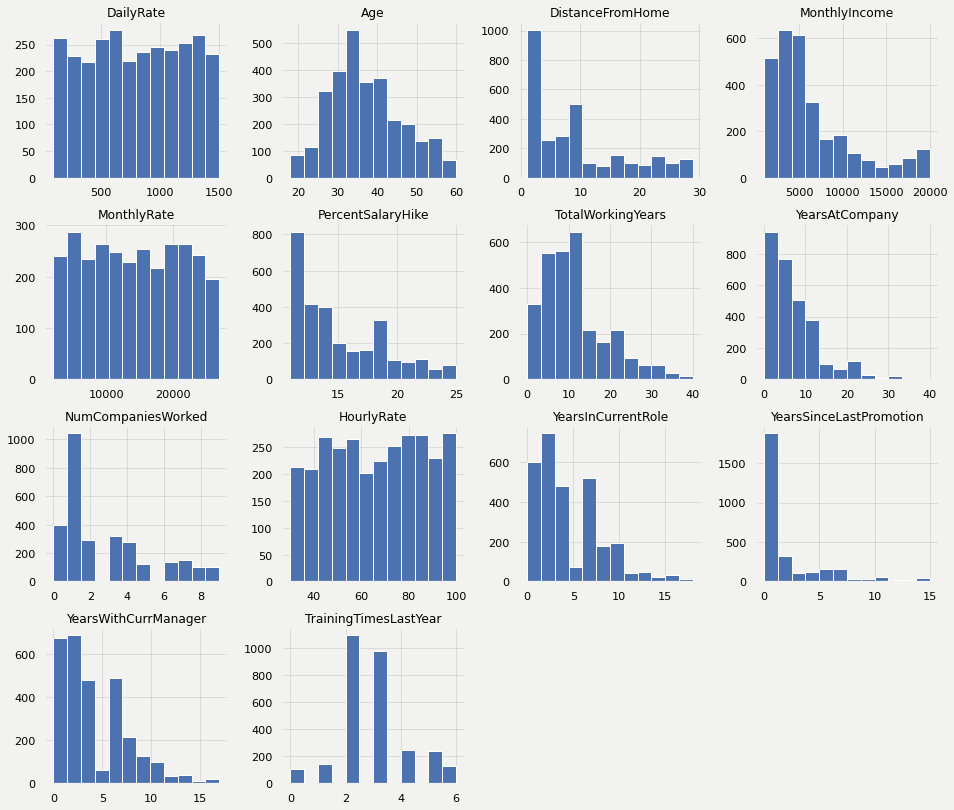

In [16]:
#creating histograms
df[num_cols].hist(bins=12, figsize=(16,14))
plt.show()

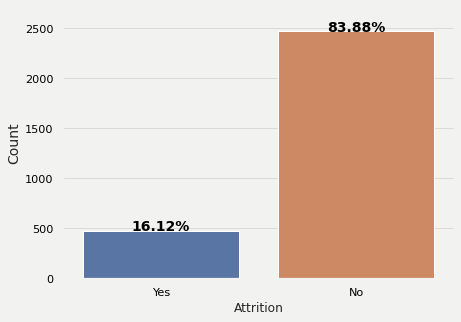

In [17]:
total = len(df)
plt.figure(figsize=(7,5))
g = sns.countplot(x='Attrition', data=df)
g.set_ylabel('Count', fontsize=14)
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height + 1.5,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=14, fontweight='bold')
plt.margins(y=0.1)
plt.show()

**Observations:**

- **The age distribution is close to a normal distribution** with the majority of employees between the ages of 25 and 50.

- **The percentage salary hike is skewed to the right**, which means employees are mostly getting lower percentage salary increases.

- **MonthlyIncome and TotalWorkingYears are skewed to the right**, indicating that the majority of workers are in entry / mid-level positions in the organization.

- **DistanceFromHome also has a right skewed distribution**, meaning most employees live close to work but there are a few that live further away.

- **On average, an employee has worked at 2.5 companies.** Most employees have worked at only 1 company.

- **The YearsAtCompany variable distribution shows a good proportion of workers with 10+ years**, indicating a significant number of loyal employees at the organization. 

- **The YearsInCurrentRole distribution has three peaks at 0, 2, and 7.** There are a few employees that have even stayed in the same role for 15 years and more.

- **The YearsSinceLastPromotion variable distribution indicates that some employees have not received a promotion in 10-15 years and are still working in the organization.** These employees are assumed to be high work-experience employees in upper-management roles, such as co-founders, C-suite employees and the like.

- The distributions of DailyRate, HourlyRate and MonthlyRate appear to be uniform and do not provide much information. It could be that daily rate refers to the income earned per extra day worked while hourly rate could refer to the same concept applied for extra hours worked per day. Since these rates tend to be broadly similiar for multiple employees in the same department, that explains the uniform distribution they show. 

### **Univariate analysis for categorical variables**

In [18]:
#Printing the % sub categories of each category
for i in cat_cols:
    print(df[i].value_counts(normalize=True).to_frame())
    print('*'*40)

     Attrition
No    0.838776
Yes   0.161224
****************************************
     OverTime
No   0.717007
Yes  0.282993
****************************************
                   BusinessTravel
Travel_Rarely            0.709524
Travel_Frequently        0.188435
Non-Travel               0.102041
****************************************
                        Department
Research & Development    0.653741
Sales                     0.303401
Human Resources           0.042857
****************************************
   Education
3   0.389116
4   0.270748
2   0.191837
1   0.115646
5   0.032653
****************************************
                  EducationField
Life Sciences           0.412245
Medical                 0.315646
Marketing               0.108163
Technical Degree        0.089796
Other                   0.055782
Human Resources         0.018367
****************************************
   JobSatisfaction
4         0.312245
3         0.300680
1         0.196599
2     

In [19]:
def cat_count_plot(data: pd.DataFrame, cat_cols: list, title: str, n_cols: int = 2, figsize: list = [16, 26]) -> None:
    fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(figsize[0], figsize[1]))
    for i, feature in enumerate(cat_cols, 1):    
        plt.subplot(len(cat_cols), n_cols, i)
        sns.countplot(
            x=feature, 
            data=data,
            order=data[f'{feature}'].value_counts()\
                                    .sort_values(ascending=False).index)
        plt.title(f'{feature}', size=14, fontsize=14)
        plt.xticks(rotation=90)
        plt.xlabel('')
    fig.suptitle(f'{title}', fontsize=18)
    plt.tight_layout()
    fig.subplots_adjust(top=0.945)
    plt.show()

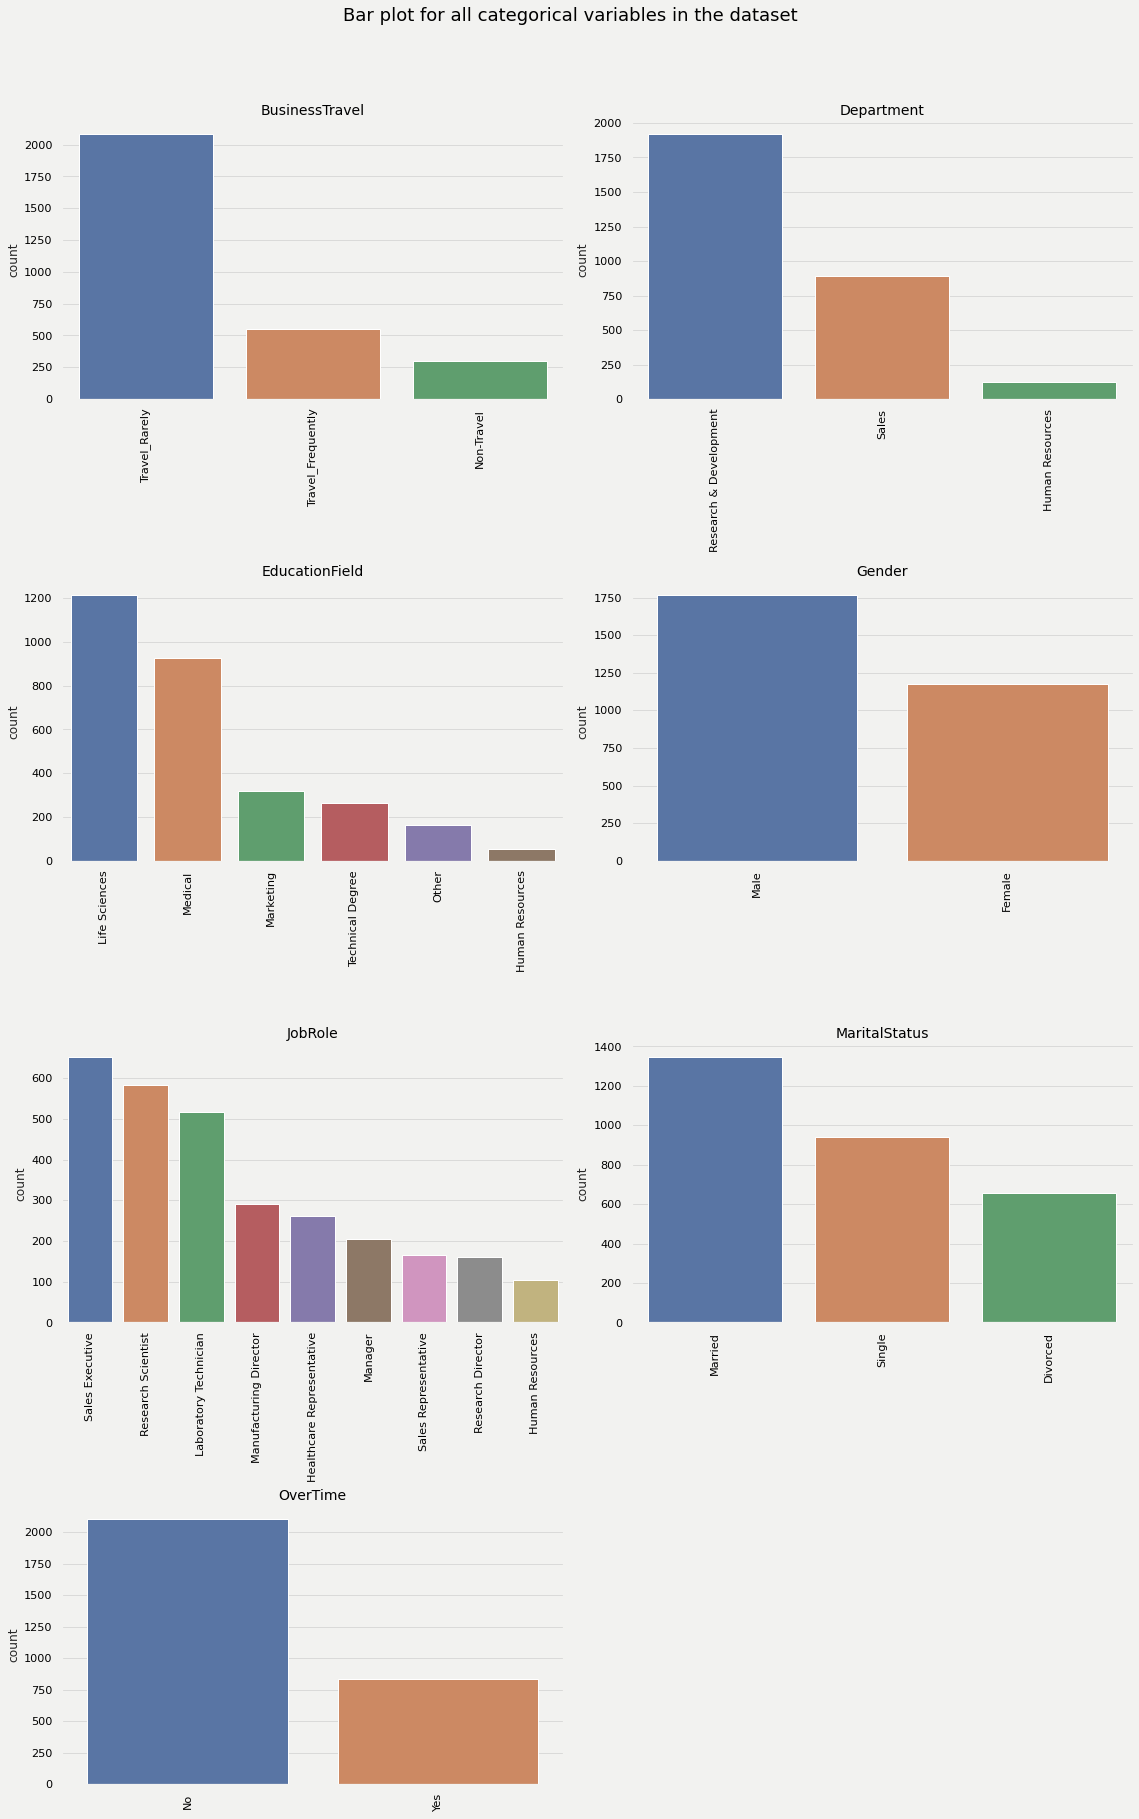

In [20]:
cat_count_plot(
    data=df,
    cat_cols=df.select_dtypes(include=np.object).columns[1:],
    title='Bar plot for all categorical variables in the dataset',
    n_cols=2,
    figsize=[16, 45]
)

**Observations:**

- **The employee attrition rate is 16%.**
- **Around 28% of the employees are working overtime.** This number appears to be on the higher side, and might indicate a stressed employee work-life.
- 71% of the employees have traveled rarely, while around 19% have to travel frequently.
- Around 73% of the employees come from an educational background in the Life Sciences and Medical fields. 
- Over 65% of employees work in the Research & Development department of the organization.
- **Nearly 40% of the employees have low (1) or medium-low (2) job satisfaction** and environment satisfaction in the organization, indicating that the morale of the company appears to be somewhat low.
- **Over 30% of the employees show low (1) to medium-low (2) job involvement.** 
- Over 80% of the employees either have none or very less stock options. 
- **In terms of performance ratings, none of the employees have rated lower than 3 (excellent).** About 85% of employees have a performance rating equal to 3 (excellent), while the remaining have a rating of 4 (outstanding). This could either mean that the majority of employees are top performers, or  the more likely scenerio is that the organization could be highly lenient with its performance appraisal process.

**Now that we have explored our data, let's build the model.**

### **Model Building - Approach**
1. Data preparation
2. Partition the data into train and test set.
3. Build model on the train data.
4. Tune the model if required.
5. Test the data on test set.

### **Data preparation**

**Creating dummy variables for the categorical variables**

In [21]:
#creating list og dummy columns
to_get_dummies_for = ['BusinessTravel', 'Department', 'EducationField', 'Gender', 'MaritalStatus','JobRole']

#creating dummy variables
df = pd.get_dummies(data = df, columns= to_get_dummies_for, drop_first= True)      

#mapping ovetime and attrition
dict_OverTime = {'Yes': 1, 'No':0}
dict_attrition = {'Yes': 1, 'No': 0}


df['OverTime'] = df.OverTime.map(dict_OverTime)
df['Attrition'] = df.Attrition.map(dict_attrition)

### **Separating the independent (X) and dependent variables (Y)**

In [22]:
#Separating target variable and other variables
Y= df.Attrition
X= df.drop(['Attrition'],axis=1)

### **Splitting the data into 70% train and 30% test set**

In [23]:
#splitting the data
x_train, x_test, y_train, y_test=train_test_split(
    X,
    Y,
    test_size=0.3,
    random_state=1,
    stratify=Y
)

### **Model evaluation criterion**

#### The model can make two types of wrong predictions:
1. Predicting an employee will attrite when the employee doesn't attrite
2. Predicting an employee will not attrite and the employee actually attrites

#### Which case is more important? 
* **Predicting that the employee will not attrite but the employee attrites** i.e. losing out on a valuable employee or asset. This would be considered a major miss for any employee attrition predictor, and is hence the more important case of wrong predictions.

#### How to reduce this loss i.e the need to reduce False Negatives?
* **The company would want the Recall to be maximized**, the greater the Recall, the higher the chances of minimizing false negatives. Hence, the focus should be on increasing Recall (minimizing the false negatives) or in other words identifying the true positives (i.e. Class 1) very well, so that the company can provide incentives to control attrition rate especially for top-performers. This would help in optimizing the overall project cost towards retaining the best talent.

**Also, let's create a function to calculate and print the classification report and confusion matrix so that we don't have to rewrite the same code repeatedly for each model.**

In [24]:
#creating metric function 
def metrics_score(actual, predicted):
    print(classification_report(actual, predicted))
    cm = confusion_matrix(actual, predicted, normalize='true')
    plt.figure(figsize=(8,5))
    sns.heatmap(
        cm, 
        annot=True,
        annot_kws={"size":14},
        fmt='.2%', 
        xticklabels=['Not Attrite', 'Attrite'], 
        yticklabels=['Not Attrite', 'Attrite']
    )
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

### **Building the model**

We will be building 2 different models:
- **Decision Tree**
- **Random Forest**


### **Building a Decision Tree Model**

* We will build our model using the **DecisionTreeClassifier function.** 
* If the frequency of class A is 17% and the frequency of class B is 83%, then class B will become the dominant class and **the decision tree will become biased toward the dominant classes.**
* **class_weight is a hyperparameter** for the decision tree classifier, and in this case, we can pass a dictionary {0:0.17,1:0.83} to the model to specify the weight of each class and the decision tree will give more weightage to class 1.

In [25]:
#building decision tree
dt = DecisionTreeClassifier(
    class_weight='balanced',
    # class_weight={0:0.17, 1:0.83}, 
    random_state=1
)

In [26]:
#fitting decision tree
dt.fit(x_train, y_train)

DecisionTreeClassifier(class_weight='balanced', random_state=1)

**Let's check the model performance of decision tree**

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1726
           1       1.00      1.00      1.00       332

    accuracy                           1.00      2058
   macro avg       1.00      1.00      1.00      2058
weighted avg       1.00      1.00      1.00      2058



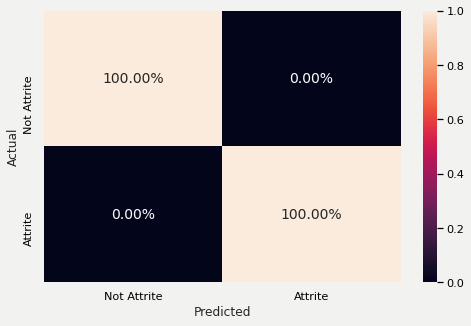

In [27]:
#checking performance on train dataset
y_train_pred_dt=dt.predict(x_train)
metrics_score(y_train,y_train_pred_dt)

**Observations:**
- The Decision tree is giving a **100% result on the training dataset.**

              precision    recall  f1-score   support

           0       0.97      0.96      0.97       740
           1       0.81      0.86      0.84       142

    accuracy                           0.95       882
   macro avg       0.89      0.91      0.90       882
weighted avg       0.95      0.95      0.95       882



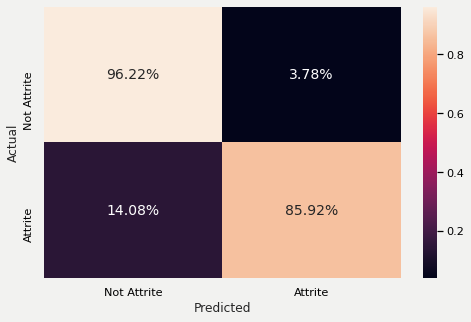

In [28]:
#checking performance on test dataset
y_test_pred_dt=dt.predict(x_test)
metrics_score(y_test,y_test_pred_dt)

**Observations:**

- The Decision Tree works well on the training data but **not so well on the test data** as the recall is 0.83 as compared to 1 for training dataset. i.e. The Decision Tree is over fitting on the data.
- The precision on the test data suggests that there's a 25% (1-0.75) chance that the model will predict that a person is going to leave even though he/she would not, and **the company may waste their time and energy on these employees who are not at risk of attrition.**

**Let's plot the feature importance and check the most important features:**

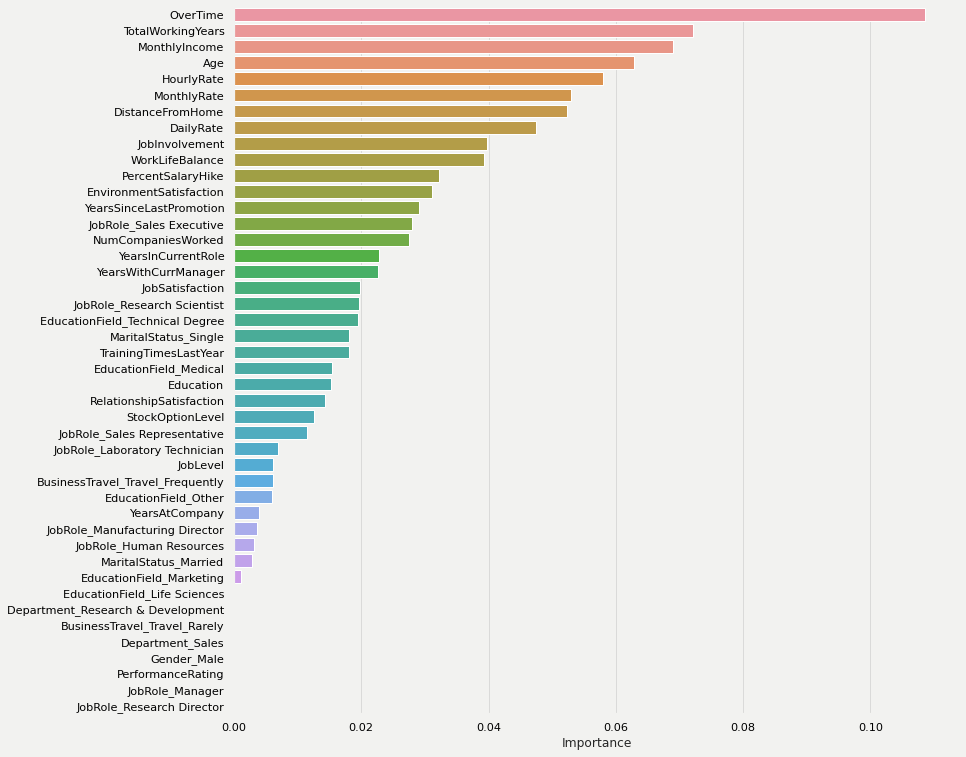

In [29]:
#plotting the importance plot
importances = dt.feature_importances_
columns=X.columns
importance_df=pd.DataFrame(importances,index=columns, columns=['Importance']).sort_values(by='Importance',ascending=False)
plt.figure(figsize=(13,13))
sns.barplot(importance_df.Importance,importance_df.index);

**Observations:**
- According to the Decision Tree, **Overtime is the most important feature, followed by Age, total working years and Monthly income.** 
- This might signify that people who are at risk of attrition have low income, are doing overtime and have less experience. 
- The other important features are dailyrate, distance from home, job involvement and percentage salary hike.

**Let's try to tune the model and check if we could improve the results.**

### **Tuning Models**

### **Using GridSearch for Hyperparameter Tuning on the model**

* Hyperparameter tuning is also tricky in the sense that **there is no direct way to calculate how a change in the hyperparameter value will reduce the loss of your model**, so we usually resort to experimentation. We'll use Grid search to perform hyperparameter tuning.
* **Grid search is a tuning technique that attempts to compute the optimum values of hyperparameters.** 
* **It is an exhaustive search** that is performed on a the specific parameter values of a model.
* The parameters of the estimator/model used to apply these methods are **optimized by cross-validated grid-search** over a parameter grid.

**Criterion{“gini”, “entropy”}**

The function to measure the quality of a split. Supported criteria are “gini” for the Gini impurity and “entropy” for the information gain.

**max_depth** 

The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.

**min_samples_leaf**

The minimum number of samples required to be at a leaf node. A split point at any depth will only be considered if it leaves at least min_samples_leaf training samples in each of the left and right branches. This may have the effect of smoothing the model, especially in regression.

### Decision Tree Parameters

| Parameter                | Default | Options                                                                                                                                                               | Description                                                                                                                                                                                                             |
|--------------------------|---------|-----------------------------------------------------------------------------------------------------------------------------------------------------------------------|-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| criterion                | gini    | Regression: MSE, MAE Classification: Gini impurity, Cross Entropy                                                                                                     | Metric to evaluate split quality.                                                                                                                                                                                       |
| splitter                 | best    | best, random                                                                                                                                                          | How to choose the split at each node. Supported strategies are “best” to choose the best split and “random” to choose the best random split.                                                                            |
| max_depth                | None    | int                                                                                                                                                                   | Max # of levels in tree. Split nodes until max_depth is reached or all leaves are pure or all leaves contain less than min_samples_split samples.                                                                       |
| max_features             | None    | None: max_features=n_features; int; float (fraction): int(max_features * n_features)  auto, sqrt: max_features=sqrt(n_features). log2: max_features=log2(n_features). | # of features to consider when evaluating split                                                                                                                                                                         |
| max_leaf_nodes           | None    | None: unlimited # of leaf nodes int                                                                                                                                   | Continue to split nodes that reduce relative impurity the most until reaching max_leaf_nodes.                                                                                                                           |
| min_impurity_decrease    | 0       | float                                                                                                                                                                 | Split node if impurity decreases by at least this value.                                                                                                                                                                |
| min_samples_leaf         | 1       | int; float (as percentage of N)                                                                                                                                       | Minimum # of samples to be at a leaf node. A split will only be considered if there are at least min_samples_leaf training samples in each of the left and right branches. May smoothen the model, esp. for regression. |
| min_samples_split        | 2       | int; float (as percentage of N)                                                                                                                                       | The minimum number of samples required to split an internal node:                                                                                                                                                       |
| min_weight_fraction_leaf | 0       | NA                                                                                                                                                                    | The minimum weighted fraction of the sum total of weights (of all the input samples) required to be at a leaf node. Samples have equal weight when sample_weight is not provided (in fit method).                       |
| presort                  | False   | NA                                                                                                                                                                    | Sort the data to speed up the search for best splits during training. Can slow down training on 'large' datasets but may speed up training on small data or with small max_depth setting.                               |
| class_weight             | None    | balanced: inversely proportional to class frequencies dict: {class_label: weight} list of dicts (for multi-output)                                                    | Weights associated with classes                                                                                                                                                                                         |

In [30]:
# Choose the type of classifier. 
dtree_estimator = DecisionTreeClassifier(
    class_weight='balanced',
    # class_weight={0:0.17,1:0.83}, 
    random_state=1
)

# Grid of parameters to choose from
parameters = {'max_depth': [None] + list(np.arange(2,7)), 
              'criterion': ['gini', 'entropy'],
              'min_samples_leaf': [2, 5, 10, 20, 25]
             }

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(recall_score, pos_label=1)

# Run the grid search
gridCV= GridSearchCV(
    dtree_estimator, 
    parameters, 
    scoring=scorer, 
    # cv=10, 
    cv=12,
    n_jobs=-1
)

gridCV = gridCV.fit(x_train, y_train)

# Set the clf to the best combination of parameters
dtree_estimator = gridCV.best_estimator_

# Fit the best algorithm to the data. 
dtree_estimator.fit(x_train, y_train)

DecisionTreeClassifier(class_weight='balanced', min_samples_leaf=5,
                       random_state=1)

              precision    recall  f1-score   support

           0       1.00      0.91      0.95      1726
           1       0.67      0.99      0.80       332

    accuracy                           0.92      2058
   macro avg       0.83      0.95      0.87      2058
weighted avg       0.95      0.92      0.93      2058



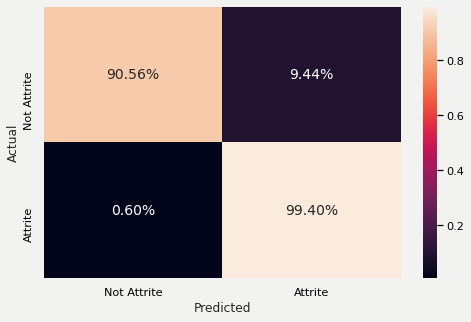

In [31]:
y_train_pred_dt=dtree_estimator.predict(x_train)
metrics_score(y_train,y_train_pred_dt)

**Observations:**
- As compared to the base model, **the performance on the training set has gone down significantly.**

              precision    recall  f1-score   support

           0       0.97      0.84      0.90       740
           1       0.51      0.89      0.65       142

    accuracy                           0.84       882
   macro avg       0.74      0.86      0.77       882
weighted avg       0.90      0.84      0.86       882



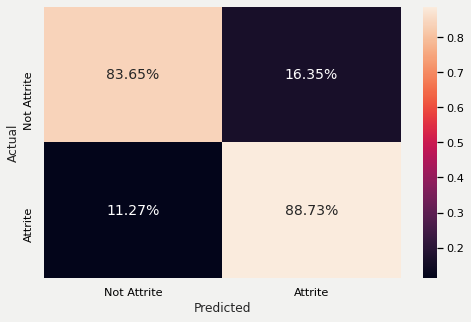

In [32]:
y_test_pred_dt=dtree_estimator.predict(x_test)
metrics_score(y_test,y_test_pred_dt)

In [33]:
#!python -m pip install --user yellowbrick

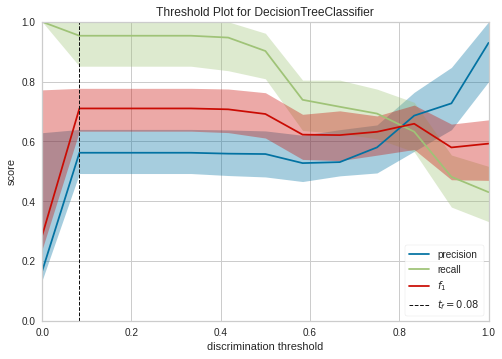

In [34]:
from yellowbrick.classifier import DiscriminationThreshold

visualizer = DiscriminationThreshold(
    dtree_estimator, 
    cv=0.1, 
    n_trials=50,
    exclude='queue_rate'
)

visualizer.fit(
    np.concatenate((x_train, x_test), axis=0), 
    np.concatenate((y_train, y_test), axis=0)
)        
# Fit the data to the visualizer
visualizer.show();

              precision    recall  f1-score   support

           0       1.00      0.90      0.95      1726
           1       0.65      1.00      0.79       332

    accuracy                           0.91      2058
   macro avg       0.83      0.95      0.87      2058
weighted avg       0.94      0.91      0.92      2058



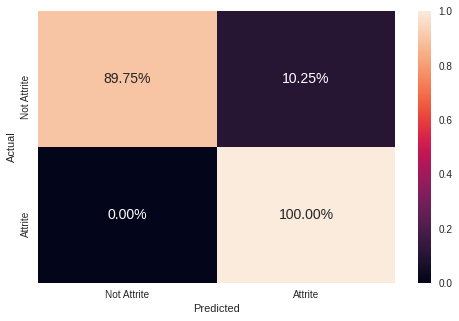

In [35]:
optimal_threshold1= 0.09
y_pred_train_dtree = dtree_estimator.predict_proba(x_train)
metrics_score(y_train, y_pred_train_dtree[:,1]>optimal_threshold1)

              precision    recall  f1-score   support

           0       0.98      0.83      0.90       740
           1       0.50      0.90      0.64       142

    accuracy                           0.84       882
   macro avg       0.74      0.86      0.77       882
weighted avg       0.90      0.84      0.86       882



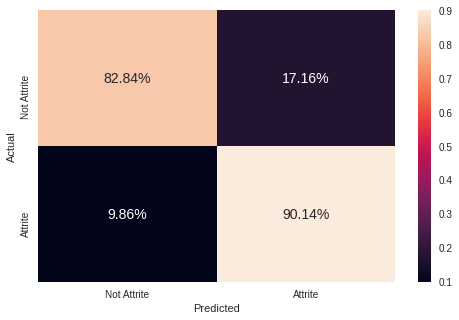

In [36]:
y_pred_test_dtree = dtree_estimator.predict_proba(x_test)
metrics_score(y_test, y_pred_test_dtree[:,1]>optimal_threshold1)

**Observations:**
- The tuned model is not performing as well as the previous/base model.
- This model is not overfitting on the training data, and giving approx. the same result on the test and train datasets.
- Precision has gone down significantly from .75 to .29 as compared to the previous model. which means the tuned model will give a high number of false positives i.e. this model will predict the employee is going to leave even if they won't, and this will cost time and effort to the company.

**Let's look at the feature impotance of this model and try to analyse why this is happening.**

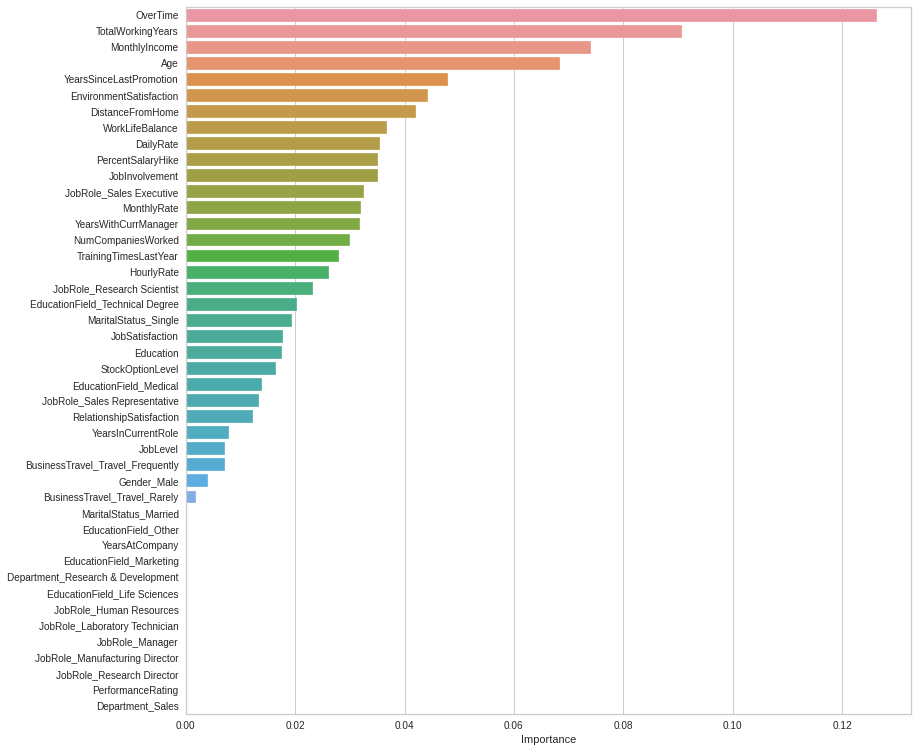

In [37]:
importances = dtree_estimator.feature_importances_
columns=X.columns
importance_df=pd.DataFrame(importances,index=columns,columns=['Importance']).sort_values(by='Importance',ascending=False)
plt.figure(figsize=(13,13))
sns.barplot(importance_df.Importance,importance_df.index);

**Observations:**
- After tuning the model we are getting that only 3 features are important. It seems like **the model is having high bias**, as it has over-simplified the problem and is not capturing the patterns associated with other variables.
- According to this model too OverTime, TotalWorkingYears and MonthlyIncome are the 3 most important features that describe why an employee is leaving the organization, which might imply that employees doing overtime may feel that their remuneration is not enough for their efforts.

**Let's plot the tree and check if the assumptions about overtime income are true**

As we know, the decision tree keeps growing until the nodes are homogeneous i.e. it has only one class and the dataset here has a lot of features.

It would be hard to visualize the whole tree with so many features. Therefore we are only visualizing the tree upto max_depth=4.

In [38]:
# !python -m pip install --user graphviz

In [39]:
import graphviz
from sklearn.tree import export_graphviz

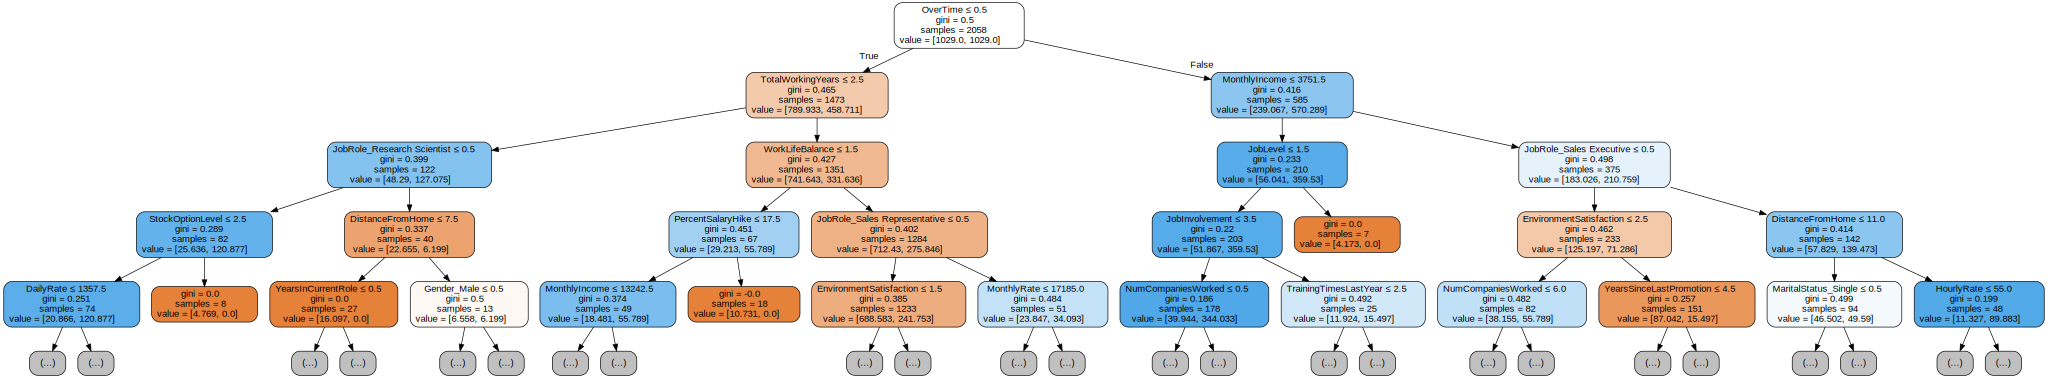

In [40]:
out_file = './sklearn_dtree.dot'

dot_data = export_graphviz(dtree_estimator,
                           out_file=None,
                           feature_names=list(X.columns),
                           max_depth=4,
                           filled=True,
                           rounded=True,
                           special_characters=True)
graphviz.Source(dot_data)

```python
features = list(X.columns)

plt.figure(figsize=(30,20))

tree.plot_tree(dt,max_depth=4,feature_names=features,filled=True,fontsize=12,node_ids=True,class_names=True)
plt.show()
```

**Note:** Blue leaves represent the eligible class i.e. **y[1]** and the orange leaves represent the non-eligible class i.e. **y[0]**. Also, the more the number of observations in a leaf, the darker its color gets.

**Observations:**
- Employees who are doing overtime with low salary and low age have a chance of leaving the company, as they might feel overworked and underpaid and might be looking for better opportunities.
- Employees who are doing overtime with low salary and are not research scientists have a high chance of attriting. 
- Employees, even if they have an income over 3751.5 units but working as sales executives and and living far from home have a high chance of attriting.
- Another segment of people are who are doing overtime, with ages younger than 33.5 and not working as junior research scientists, have a greater chance of attrition. This implies that the model suggests except for the junior research scientist role, everyone who is young has a high tendency to attrite.
- Employees who have over 2.5 years of work experience but low work life balance and low percentage hike also tend to attrite, probably as they are seeking a more balanced life.
- Employees who are not doing overtime, have low experience and are working as junior research scientists have a small chance of attriting. These employees are comfortable or loyal to the organization.
- Numcompaniesworked also seems to be an important variable in predicting if an employee's likely to attrite.

### **Building the Random Forest Classifier**

**Random Forest is a bagging algorithm where the base models are Decision Trees.** Samples are taken from the training data and on each sample a decision tree makes a prediction. 

**The results from all the decision trees are combined together and the final prediction is made using voting or averaging.**

In [42]:
#Fitting the decision tree classifier on the training datarf_estimator
rf_estimator = RandomForestClassifier(
    class_weight = 'balanced',
    #class_weight={0:0.17,1:0.83}, 
    random_state=1,
    n_jobs=-1,
)

rf_estimator.fit(x_train, y_train)

RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=1)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1726
           1       1.00      1.00      1.00       332

    accuracy                           1.00      2058
   macro avg       1.00      1.00      1.00      2058
weighted avg       1.00      1.00      1.00      2058



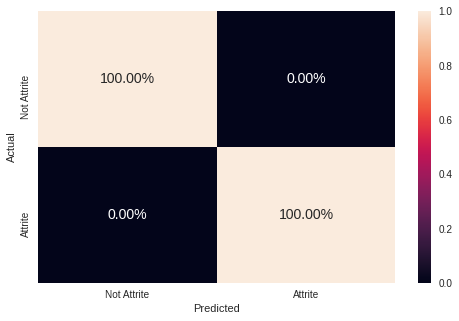

In [43]:
#Checking performance on the training data
y_pred_train_rf = rf_estimator.predict(x_train)
metrics_score(y_train, y_pred_train_rf)

**Observations:**
- The Random Forest is giving a **100% result on the training dataset.** 

              precision    recall  f1-score   support

           0       0.96      0.99      0.98       740
           1       0.97      0.79      0.87       142

    accuracy                           0.96       882
   macro avg       0.96      0.89      0.92       882
weighted avg       0.96      0.96      0.96       882



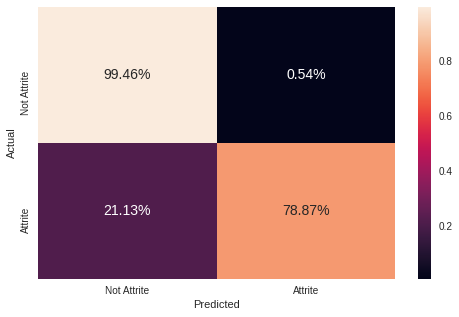

In [44]:
#Checking performance on the testing data
y_pred_test_rf = rf_estimator.predict(x_test)
metrics_score(y_test, y_pred_test_rf)

**Observations:**
- The Random Forest classifier **seems to be overfitting on the data**, since the training recall is 1 and the testing recall is only ~0.80.
- Precision on the test data using the Random Forest is doing very well. 

**Let's check the feature importance of the Random Forest:**

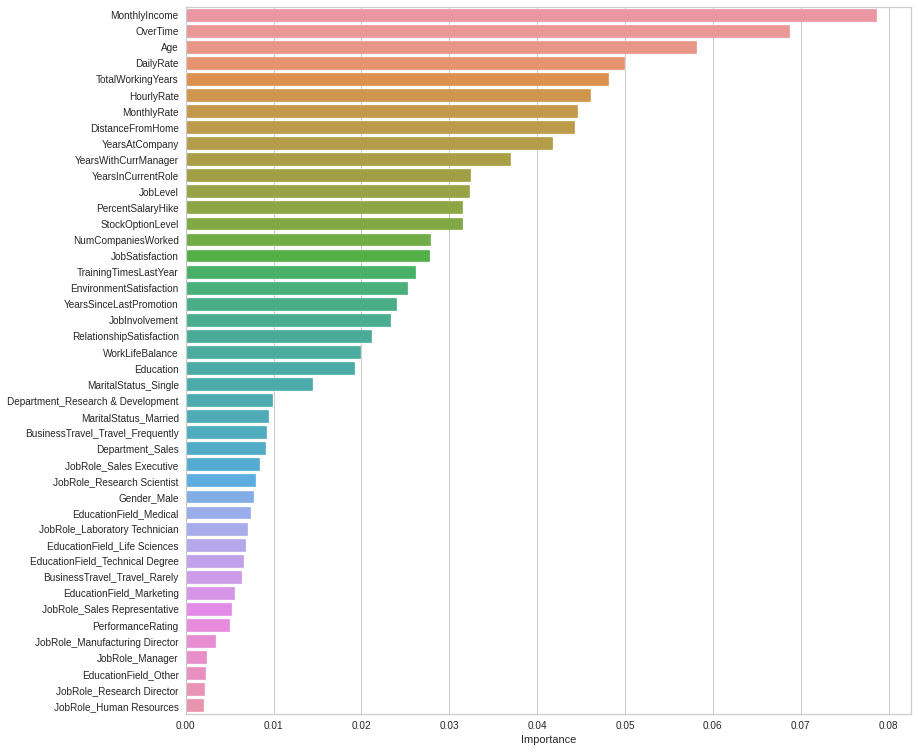

In [45]:
importances = rf_estimator.feature_importances_
columns=X.columns
importance_df=pd.DataFrame(importances,index=columns,columns=['Importance']).sort_values(by='Importance',ascending=False)
plt.figure(figsize=(13,13))
sns.barplot(importance_df.Importance,importance_df.index);

**Observations:**
- The Random Forest further verifies the results from the decision tree - the most important features are Monthy income, age, overtime, total working years and daily rate.
- We can say that the people appear to be leaving the organization because of the overtime they are doing and because they are not paid accordingly. These might be mostly junior-level and mid-level employees with less experience. 
- Distance from home is also a key feature, probably as employees living far from the office have to travel a lot, making their schedules hectic.
- Not having stock options is also a driver for attrition - this feature seems to have good importance in both the decision tree and random forest models. This could be related to the junior level employees and their lack of stock options - with the additional burden of a lower salary and working overtime, those without stock options could also be attriting more.
- Other features like number of companies worked and percent salary hike also seem to be intutive in explaining attrition likelihood, as people who have worked in a large number of companies are probably not going to stay loyal to the current organization and may have a high risk of attrition, while if an employee is not getting enough of a salary hike, that might demotivate them and lead to a higher likelihood of attriting as well.
- Other features such as job satisfaction, environment satisfaction and their job level also play a crucial role in knowing whether an employee will attrite or not.

### **Tuning the Random Forest**

**n_estimators**: The number of trees in the forest.

**min_samples_split**: The minimum number of samples required to split an internal node:

**min_samples_leaf**: The minimum number of samples required to be at a leaf node. 

**max_features{“auto”, “sqrt”, “log2”, 'None'}**: The number of features to consider when looking for the best split.

- If “auto”, then max_features=sqrt(n_features).

- If “sqrt”, then max_features=sqrt(n_features) (same as “auto”).

- If “log2”, then max_features=log2(n_features).

- If None, then max_features=n_features.

The following tables lists additional options for the two `RandomForest` classes:

| Keyword      | Default | Description                                                                                                                |
|--------------|---------|----------------------------------------------------------------------------------------------------------------------------|
| bootstrap    | True    | Bootstrap samples during training                                                                                          |
| n_estimators | 10      | # trees in the forest.                                                                                                     |
| oob_score    | False   | Use out-of-bag samples to estimate the error on unseen data                                                                   |
| warm_start   | False   | Reuse result of previous call to continue training and add more trees to the ensemble, otherwise, train a whole new forest |

In [339]:
# Choose the type of classifier. 
rf_estimator_tuned = RandomForestClassifier(
    class_weight = 'balanced',
    # class_weight={0:0.17,1:0.83}, 
    random_state=1,
    n_jobs=-1,
)

# Grid of parameters to choose from
## add from article
params_rf = {  
        "n_estimators": [200, 250, 275, 300],
        "min_samples_leaf": [1, 2, 3, 4], 
        "max_features": [0.7, 0.8, 0.9, 'auto'],
}


# Type of scoring used to compare parameter combinations - recall score for class 1
scorer = metrics.make_scorer(recall_score, pos_label=1)

# Run the grid search
grid_obj = GridSearchCV(
    rf_estimator_tuned, 
    params_rf, 
    scoring=scorer, 
    cv=5,
    n_jobs=-1,
    return_train_score=True,
    verbose=12
)
grid_obj = grid_obj.fit(x_train, y_train)

# Set the clf to the best combination of parameters
rf_estimator_tuned = grid_obj.best_estimator_

Fitting 5 folds for each of 64 candidates, totalling 320 fits


In [340]:
pd.Series(grid_obj.best_params_)

max_features          0.8
min_samples_leaf      4.0
n_estimators        300.0
dtype: float64

In [341]:
rf_estimator_tuned.fit(x_train, y_train)

RandomForestClassifier(class_weight='balanced', max_features=0.8,
                       min_samples_leaf=4, n_estimators=300, n_jobs=-1,
                       random_state=1)

              precision    recall  f1-score   support

           0       1.00      0.99      1.00      1726
           1       0.97      1.00      0.98       332

    accuracy                           0.99      2058
   macro avg       0.99      1.00      0.99      2058
weighted avg       0.99      0.99      0.99      2058



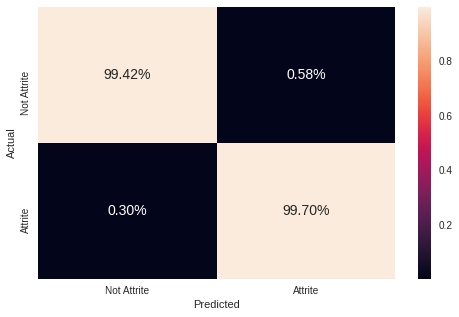

In [342]:
#Checking performance on the training data
y_pred_train_rf_tuned = rf_estimator_tuned.predict(x_train)
metrics_score(y_train, y_pred_train_rf_tuned)

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       740
           1       0.85      0.82      0.84       142

    accuracy                           0.95       882
   macro avg       0.91      0.90      0.90       882
weighted avg       0.95      0.95      0.95       882



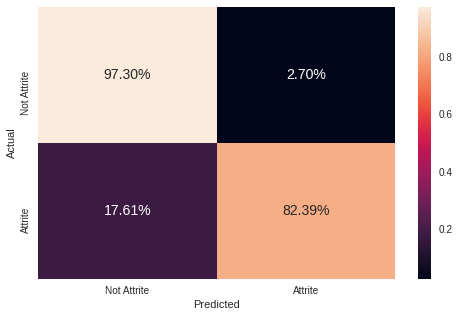

In [343]:
#Checking performance on the test data
y_pred_test_rf_tuned = rf_estimator_tuned.predict(x_test)
metrics_score(y_test, y_pred_test_rf_tuned)

**Observations:**
- The tuned model is also comparatively overfitting on the training dataset, but **it shows a very good performance on the test dataset.**
- **The recall for the tuned model has improved from 79% to 83%** with a small decrease in precision. 
- **This model is the best-performing one among all the models so far,** and is giving us good precision and recall scores on the test dataset.

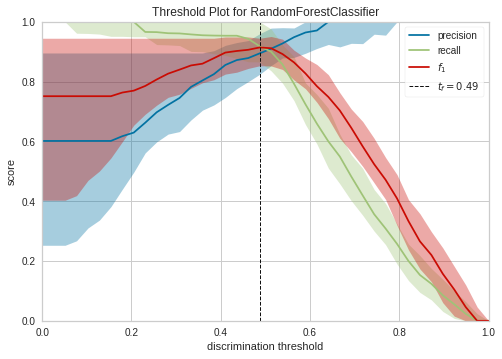

In [344]:
visualizer = DiscriminationThreshold(
    rf_estimator_tuned, 
    cv=0.1, 
    n_trials=50,
    exclude='queue_rate'
)

visualizer.fit(
    np.concatenate((x_train, x_test), axis=0), 
    np.concatenate((y_train, y_test), axis=0)
)        
# Fit the data to the visualizer
visualizer.show();

In [345]:
rf_estimator_tuned.fit(x_train, y_train)

RandomForestClassifier(class_weight='balanced', max_features=0.8,
                       min_samples_leaf=4, n_estimators=300, n_jobs=-1,
                       random_state=1)

              precision    recall  f1-score   support

           0       1.00      0.99      1.00      1726
           1       0.97      1.00      0.98       332

    accuracy                           0.99      2058
   macro avg       0.98      1.00      0.99      2058
weighted avg       0.99      0.99      0.99      2058



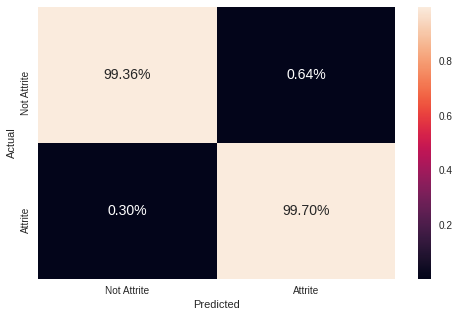

In [346]:
optimal_threshold1= 0.49
y_pred_train_dtree = rf_estimator_tuned.predict_proba(x_train)
metrics_score(y_train, y_pred_train_dtree[:,1]>optimal_threshold1)

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       740
           1       0.85      0.82      0.84       142

    accuracy                           0.95       882
   macro avg       0.91      0.90      0.90       882
weighted avg       0.95      0.95      0.95       882



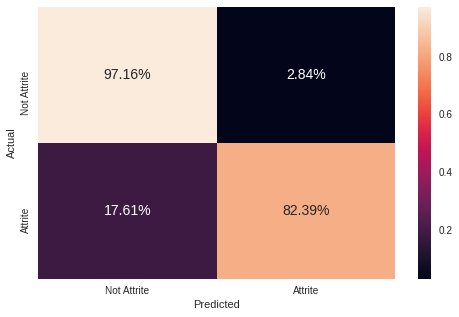

In [347]:
y_pred_test_dtree = rf_estimator_tuned.predict_proba(x_test)
metrics_score(y_test, y_pred_test_dtree[:,1]>optimal_threshold1)

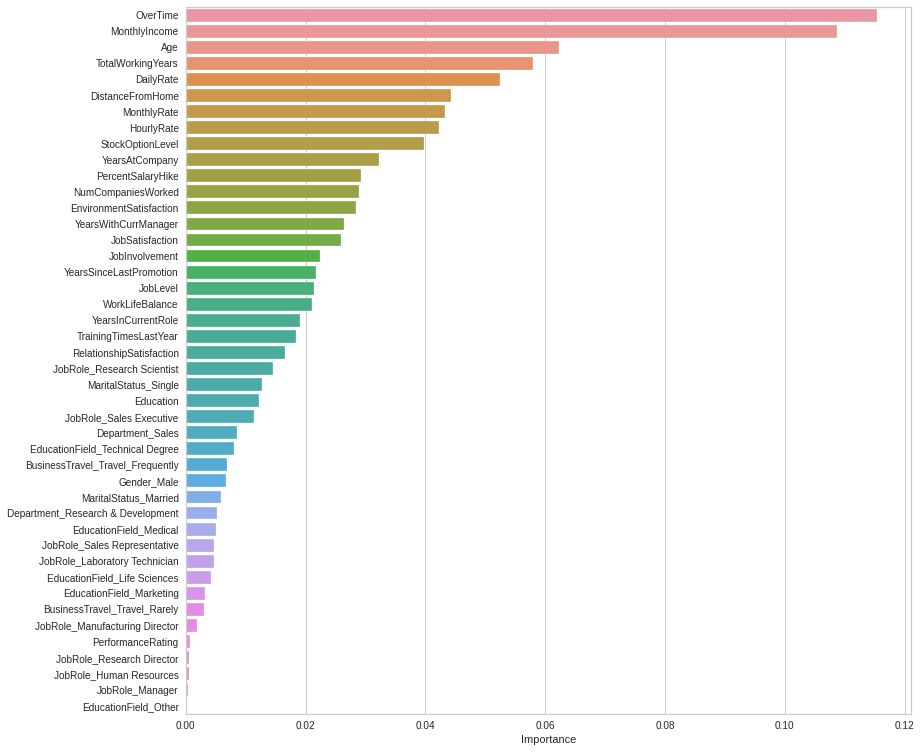

In [348]:
#plotting feature importance
importances = rf_estimator_tuned.feature_importances_
columns=X.columns
importance_df=pd.DataFrame(importances,index=columns,columns=['Importance']).sort_values(by='Importance',ascending=False)
plt.figure(figsize=(13,13))
sns.barplot(importance_df.Importance,importance_df.index);

**Observations:**
- **The feature importance plot for the base model and tuned model are quite similar** - the model seems to suggest that OverTime, MonthlyIncome, Age,TotalWorkingYears and DailyRate are the most important features.
- Other important features are DistanceFromHome, StockOptionLevel, YearsAt Company and NumCompaniesWorked.

### **Conclusion**

- The best model we have got so far is the tuned random forest model which is giving nearly ~85% recall on the test data .
- They company should use this model to know beforehand which employee is going to attrirte and act accordingly. 
- Overtime, monthly income, dailyrate, number of companies worked and work experience/age seem to be the most important features.

### **Recommendations**
- We saw that **working overtime is the most important driver of attrition.** The organization should manage their work more efficiently so that employees don't have to work overtime and can manage to have a work-life balance, or failing this, the company could provide some additional incentives to employees who are working overtime in order to retain them.
- **A higher monthly income might lower the odds of an employee attriting.** The company should make sure that all its employees are compensated at least based on industry standards.
- As observed earlier, the organization has a lower percentage salary hike and promotions are given less frequently. The company might be able to focus on **giving promotions more frequently** or they could **increase the annual appraisal hike** to incentivise employees to stay.
- The organization could come up with a **revised CTC plan with stock options for the employees** in order to keep them motivated and invested in the company's performance. 
- The organistion should also modify its hiring policy as people who have worked in many companies and have switched a lot should not be hired very often.
- Distance from home is also an important factor for attrition - employees traveling a larger distance to reach the workplace are the ones attriting. For such employees, the company can provide cab facilities so that the commute of employees gets easier.
- The company should also keep track of the hourly rate or the daily rate, so that when the employees need to stay overtime for extra work they are well compansated for that.
- The organization should focus on improving the culture and environment at the workplace by coming up with new ideas to make the envionment more open and friendly.
- Keeping track of the problems which employees with lesser experience face and how the management can help them, will create a healthy envionment for the young employees.
- The organisation should also focus on the employees who are working in sales and marketing, as attrition rate is quite high for these deparments. Perhaps the company could look into their incentive schemes and try to come up with new incentive methods to motivate them to stay.

In [349]:
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap

def plot_decision_boundary(X, y, test, model, steps=1000, cmap=plt.cm.RdBu, mesh_step=0.25):
    """
    Function to plot the decision boundary and data points of a model.
    Data points are colored based on their actual label.
    """
    Xtrain_PCA = PCA(n_components=2).fit_transform(X.values)
    Xtest_PCA = PCA(n_components=2).fit_transform(test.values)
    model.fit(Xtrain_PCA, y)
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    # Define region of interest by data limits
    xmin, xmax = Xtrain_PCA[:,0].min() - mesh_step, Xtrain_PCA[:,0].max() + mesh_step
    ymin, ymax = Xtrain_PCA[:,1].min() - mesh_step, Xtrain_PCA[:,1].max() + mesh_step
    steps = 1000
    x_span = np.linspace(xmin, xmax, steps)
    y_span = np.linspace(ymin, ymax, steps)
    xx, yy = np.meshgrid(x_span, y_span)
    # Make predictions across region of interest
    labels = model.predict(np.c_[xx.ravel(), yy.ravel()])
    # Plot decision boundary in region of interest
    z = labels.reshape(xx.shape)
    fig, ax = plt.subplots(figsize=(10,6))
    ax.contourf(xx, yy, z, cmap=cmap, alpha=0.7)
    # Get predicted labels on training data and plot
    train_labels = model.predict_proba(Xtest_PCA)[:,1]
    ax.scatter(Xtrain_PCA[:,0], Xtrain_PCA[:,1], c=y.ravel(), cmap=cm_bright, lw=0.5, alpha=0.7, s=100, edgecolor='black')
    return fig, ax

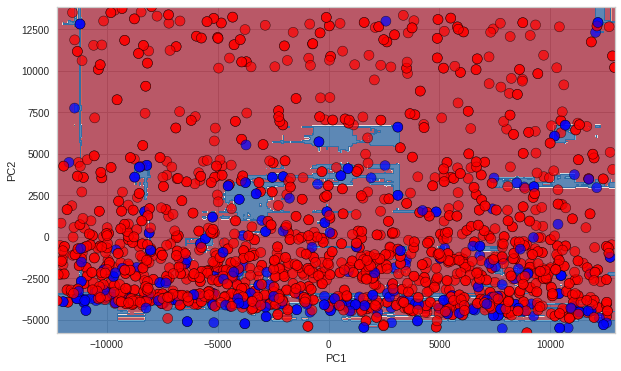

In [350]:
fig, ax = plot_decision_boundary(
    x_train, 
    y_train.values, 
    x_test,
    rf_estimator_tuned, 
    cmap = plt.cm.RdBu, 
    mesh_step = 0.05)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.margins(0.5, 0.5);

## Parameter Tuning Interpretation 

### CV Train-Test Scores

In [351]:
results = pd.DataFrame(grid_obj.cv_results_).drop('params', axis=1)
results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   mean_fit_time           64 non-null     float64
 1   std_fit_time            64 non-null     float64
 2   mean_score_time         64 non-null     float64
 3   std_score_time          64 non-null     float64
 4   param_max_features      64 non-null     object 
 5   param_min_samples_leaf  64 non-null     object 
 6   param_n_estimators      64 non-null     object 
 7   split0_test_score       64 non-null     float64
 8   split1_test_score       64 non-null     float64
 9   split2_test_score       64 non-null     float64
 10  split3_test_score       64 non-null     float64
 11  split4_test_score       64 non-null     float64
 12  mean_test_score         64 non-null     float64
 13  std_test_score          64 non-null     float64
 14  rank_test_score         64 non-null     int3

In [352]:
results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_min_samples_leaf,param_n_estimators,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,1.688219,0.047804,0.107156,0.001913,0.7,1,200,0.636364,0.671642,0.597015,...,0.602216,0.048754,55,1.0,1.0,1.0,1.0,1.0,1.0,0.0
1,2.027053,0.116768,0.138978,0.040550,0.7,1,250,0.636364,0.686567,0.597015,...,0.605201,0.053170,52,1.0,1.0,1.0,1.0,1.0,1.0,0.0
2,2.126326,0.066525,0.142317,0.045348,0.7,1,275,0.636364,0.686567,0.597015,...,0.599141,0.062304,58,1.0,1.0,1.0,1.0,1.0,1.0,0.0
3,2.224924,0.061628,0.175716,0.050193,0.7,1,300,0.636364,0.671642,0.597015,...,0.596156,0.058271,59,1.0,1.0,1.0,1.0,1.0,1.0,0.0
4,1.548412,0.051846,0.150868,0.055509,0.7,2,200,0.636364,0.731343,0.611940,...,0.623202,0.061777,44,1.0,1.0,1.0,1.0,1.0,1.0,0.0


### Get parameter values & mean test scores

In [353]:
def get_test_scores(df):
    """Select parameter values and test scores"""
    data = df.filter(like='param').join(results[['mean_test_score']])
    return data.rename(columns={c: '_'.join(c.split('_')[1:]) for c in data.columns})

In [354]:
test_scores = get_test_scores(results)
test_scores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   max_features      64 non-null     object 
 1   min_samples_leaf  64 non-null     object 
 2   n_estimators      64 non-null     object 
 3   test_score        64 non-null     float64
dtypes: float64(1), object(3)
memory usage: 2.1+ KB


In [355]:
test_scores = test_scores.set_index('test_score').stack().reset_index()
test_scores.columns= ['test_score', 'parameter', 'value']
test_scores.head(3)

,test_score,parameter,value
0,0.602216,max_features,0.7
1,0.602216,min_samples_leaf,1
2,0.602216,n_estimators,200


In [356]:
plot_data = get_test_scores(results)
plot_params = plot_data.columns[:-1].tolist()
plot_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   max_features      64 non-null     object 
 1   min_samples_leaf  64 non-null     object 
 2   n_estimators      64 non-null     object 
 3   test_score        64 non-null     float64
dtypes: float64(1), object(3)
memory usage: 2.1+ KB


In [357]:
plot_data.head(3)

,max_features,min_samples_leaf,n_estimators,test_score
0,0.7,1,200,0.602216
1,0.7,1,250,0.605201
2,0.7,1,275,0.599141


### Plot Test Scores vs Parameter Settings
The GridSearchCV result stores the average cross-validation scores so that we can analyze how different hyperparameter settings affect the outcome.

The seaborn swarm plots below show the distribution of recall test scores for all parameter values.

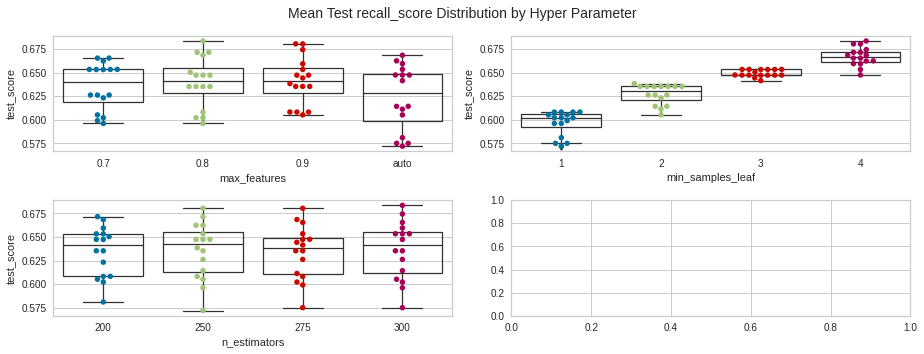

In [358]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(13, 5))
axes = axes.flatten()

for i, param in enumerate(plot_params):
    sns.swarmplot(x=param, y='test_score', data=plot_data, s=5.5, ax=axes[i])
    sns.boxplot(x=param, y='test_score', data=plot_data, linewidth=1.25, 
                boxprops={'facecolor':'None'}, ax=axes[i])
    
fig.suptitle('Mean Test recall_score Distribution by Hyper Parameter', fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=.9)
plt.show()

In [359]:
pd.Series(grid_obj.best_params_)

max_features          0.8
min_samples_leaf      4.0
n_estimators        300.0
dtype: float64

### Build Regression Tree
We will now explore how hyperparameter settings jointly affect the mean cross-validation score. To gain insight into how parameter settings interact, we can train a DecisionTreeRegressor with the mean test score as the outcome and the parameter settings, encoded as categorical variables in one-hot or dummy format.

In [360]:
from sklearn.tree import DecisionTreeRegressor

reg_tree = DecisionTreeRegressor(
    criterion='mse',
    splitter='best',
    max_depth=4,
    min_samples_split=5,
    min_samples_leaf=10,
    min_weight_fraction_leaf=0.0,
    max_features=None,
    random_state=42,
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    min_impurity_split=None,
)

#### Dummy-encode parameters

In [361]:
data = get_test_scores(results)
params = data.columns[:-1].tolist()
data = pd.get_dummies(data, columns=params, drop_first=False)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   test_score          64 non-null     float64
 1   max_features_0.7    64 non-null     uint8  
 2   max_features_0.8    64 non-null     uint8  
 3   max_features_0.9    64 non-null     uint8  
 4   max_features_auto   64 non-null     uint8  
 5   min_samples_leaf_1  64 non-null     uint8  
 6   min_samples_leaf_2  64 non-null     uint8  
 7   min_samples_leaf_3  64 non-null     uint8  
 8   min_samples_leaf_4  64 non-null     uint8  
 9   n_estimators_200    64 non-null     uint8  
 10  n_estimators_250    64 non-null     uint8  
 11  n_estimators_275    64 non-null     uint8  
 12  n_estimators_300    64 non-null     uint8  
dtypes: float64(1), uint8(12)
memory usage: 1.4 KB


In [362]:
data.tail(3)

,test_score,max_features_0.7,max_features_0.8,max_features_0.9,max_features_auto,min_samples_leaf_1,min_samples_leaf_2,min_samples_leaf_3,min_samples_leaf_4,n_estimators_200,n_estimators_250,n_estimators_275,n_estimators_300
61,0.662415,0,0,0,1,0,0,0,1,0,1,0,0
62,0.647445,0,0,0,1,0,0,0,1,0,0,1,0
63,0.659475,0,0,0,1,0,0,0,1,0,0,0,1


#### Fit Regression Tree

In [363]:
dtree_features = data.drop('test_score', axis=1).columns
reg_tree.fit(X=data[dtree_features], y=data.test_score)

DecisionTreeRegressor(max_depth=4, min_samples_leaf=10, min_samples_split=5,
                      random_state=42)

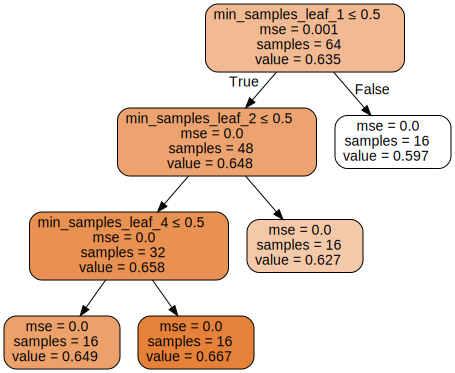

In [364]:
dot_data = export_graphviz(reg_tree,
                           out_file=None,
                           feature_names=dtree_features,
                           max_depth=4,
                           filled=True,
                           rounded=True,
                           special_characters=True)
graphviz.Source(dot_data)

```python
plt.figure(figsize=(16,16))

tree.plot_tree(reg_tree,
               max_depth=4,
               feature_names=dtree_features,
               filled=True,
               fontsize=12,
               node_ids=True,
               class_names=True
              )
plt.show()
```

#### Compute Feature Importance
Overfit regression tree to learn detailed rules that classify all samples.

In [365]:
reg_tree = DecisionTreeRegressor(
    criterion='mse',
    splitter='best',
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features=None,
    random_state=42,
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    min_impurity_split=None,
)

dtree_features = data.drop('test_score', axis=1).columns
reg_tree.fit(X=data[dtree_features], y=data.test_score)

DecisionTreeRegressor(random_state=42)

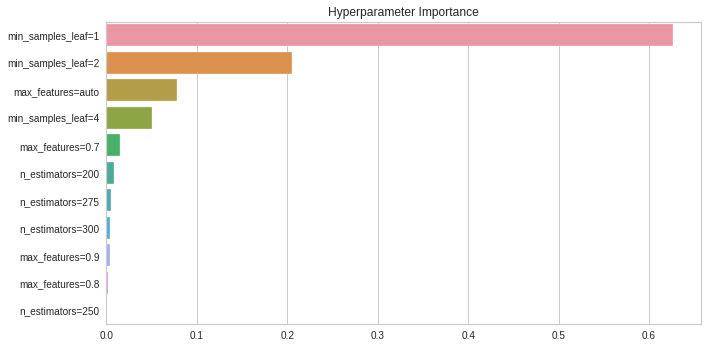

In [366]:
dtree_fi = pd.Series(reg_tree.feature_importances_, index=dtree_features).sort_values(ascending=False)
dtree_fi = dtree_fi[dtree_fi > 0]
idx = [p.split('_') for p in dtree_fi.index]
dtree_fi.index = ['_'.join(p[:-1]) + '=' + p[-1] for p in idx]

plt.figure(figsize=(10,5))
sns.barplot(x=dtree_fi.sort_values(ascending=False).values, 
            y=dtree_fi.sort_values(ascending=False).index)
plt.title('Hyperparameter Importance')
plt.tight_layout()
plt.show()

#### Run linear regression
Alternatively, we can use a linear regression to gain insights into the statistical significance of the linear relationship between hyperparameters and test scores.

In [367]:
from statsmodels.api import OLS, add_constant

In [368]:
data = get_test_scores(results)
params = data.columns[:-1].tolist()
data = pd.get_dummies(data, columns=params, drop_first=True)

model = OLS(endog=data.test_score, exog=add_constant(data.drop('test_score', axis=1))).fit(cov_type='HC3')
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             test_score   R-squared:                       0.946
Model:                            OLS   Adj. R-squared:                  0.937
Method:                 Least Squares   F-statistic:                     82.19
Date:                Sat, 18 Sep 2021   Prob (F-statistic):           2.79e-28
Time:                        19:00:39   Log-Likelihood:                 231.30
No. Observations:                  64   AIC:                            -442.6
Df Residuals:                      54   BIC:                            -421.0
Df Model:                           9                                         
Covariance Type:                  HC3                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.5962      0

##### Visualize linear regression p-values

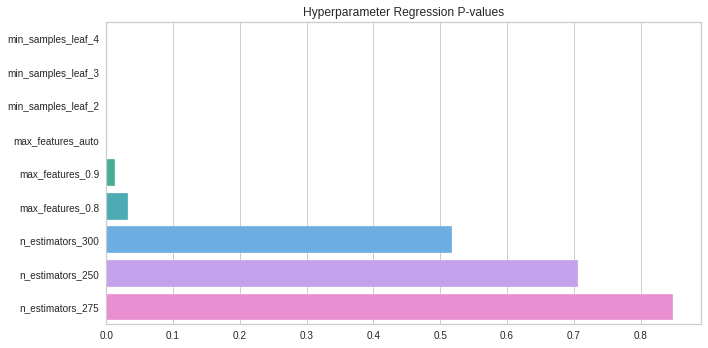

In [369]:
plt.figure(figsize=(10,5))
sns.barplot(x=model.pvalues.sort_values()[1:].values, 
            y=model.pvalues.sort_values()[1:].index)
plt.title('Hyperparameter Regression P-values')
plt.tight_layout()
plt.show()

#### Mean of residuals should be 0 and normality of error terms

In [370]:
residual = model.resid 
residual.mean()

9.020562075079397e-17

#### Test for Normality

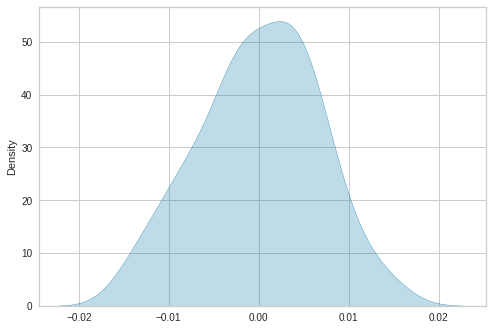

In [371]:
sns.kdeplot(residual, fill=True);

In [372]:
from scipy import stats

In [373]:
t_stat, pval = stats.shapiro(residual)
print(f't_stat: {t_stat} \npval: {pval}')

t_stat: 0.9849575757980347 
pval: 0.6267886161804199


#### Linearity of variables
It states that the predictor variables must have a linear relation with the dependent variable.

To test the assumption, we'll plot residuals and fitted values on a plot and ensure that residuals do not form a strong pattern. They should be randomly and uniformly scattered on the x-axis.

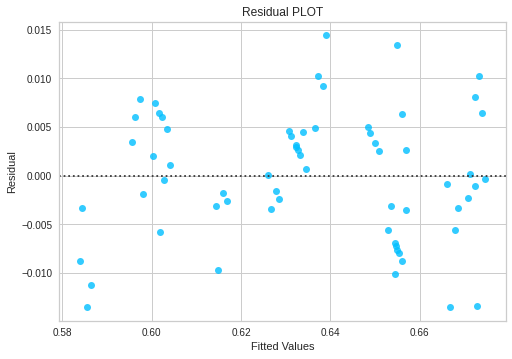

In [374]:
# predicted values
fitted = model.fittedvalues

sns.residplot(x = fitted, y = residual, color="deepskyblue")
plt.xlabel("Fitted Values")
plt.ylabel("Residual")
plt.title("Residual PLOT")
plt.show()